# AGH Modelling of Physical Systems Lab 5 (2025 April 1st)
Sylwester Arabas (sylwester.arabas@agh.edu.pl)

In [4]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot

**0. advection PDE**

Symbols:   
* ${\color{red}t}$: time   
* ${\color{blue}x}$: physical coordinate (e.g., distance or altitude)   
* ${\color{green}\psi}({\color{blue}x})$: scalar field (e.g., pollutant concentration)   
* ${\color{brown}u}$: carrier velocity field (e.g., wind)   

Transport of $\color{green}\psi$ due to advection by $\color{brown}u$ can be modelled with the advection equation:
$$ \partial_{\color{red} t} {\color{green}\psi} + \partial_{\color{blue}x} \left({\color{brown}u} {\color{green}\psi}\right) = 0 $$

For the special case of $\partial_{\color{blue}x} {\color{brown}u}=0$, an analytical solution describing translation of the signal is readily available:
$$ {\color{green}\psi}({\color{blue}x}, {\color{red}t})=\psi_0({\color{blue}x} - {\color{brown}u}{\color{red}t})$$
where $\psi_0({\color{blue}x})={\color{green}\psi}({\color{blue}x}, 0)$. 

**1. upwind descretisation**   

Symbols:   
* ${\color{red}n} = \frac{\color{red}t}{\Delta t} \in 0, 1, \ldots$   
* ${\color{blue}i} = \frac{\color{blue}x}{\Delta x} \in 0, 1, \ldots$   
* ${\color{brown}C} = {\color{brown}u}\frac{\Delta t}{\Delta x}$ (so called Courant number)   
* ${\color{green}\psi}_{\color{blue}i}^{\color{red}n}$: scalar field at "grid cell" $\color{blue}i$ in space at time "level" ${\color{red}n}$   

The explicit (forward-in-time) upwind scheme is defined as:
$$
  {\color{green}\psi}^{{\color{red}n}+1}_{\color{blue}i} = {\color{green}\psi}^{\color{red}n}_{\color{blue}i} - \left[\frac{{\color{brown}C} + |{\color{brown}C}|}{2}\left({\color{green}\psi}^{\color{red}n}_{\color{blue}i} - {\color{green}\psi}^{\color{red}n}_{{\color{blue}i}-1}\right)+\frac{{\color{brown}C}-|{\color{brown}C}|}{2}\left({\color{green}\psi}^{\color{red}n}_{{\color{blue}i}+1}-{\color{green}\psi}^{\color{red}n}_{\color{blue}i}\right)\right]
$$

or

$$
  {\color{green}\psi}^{{\color{red}n}+1}_{\color{blue}i} = {\color{green}\psi}^{\color{red}n}_{\color{blue}i} - \left[F\left({\color{green}\psi}^{\color{red}n}_{\color{blue}i},  {\color{green}\psi}^{\color{red}n}_{{\color{blue}i}+1}, {\color{brown}C_{i+1/2}^{\color{red}n}}\right)-F\left({\color{green}\psi}^{\color{red}n}_{{\color{blue}i}-1},{\color{green}\psi}^{\color{red}n}_{\color{blue}i}, {\color{brown}C_{i-1/2}^{\color{red}n}}\right)\right]
$$
$$F(\psi_L, \psi_R, C)=\frac{C+|C|}{2}\psi_L + \frac{C-|C|}{2}\psi_R$$


**2. code from previous classes: upwind algorithm coded in Python/NumPy**

In [5]:
class shift:
    def __init__(self, *, add, sub):
        self.add = add
        self.sub = sub
    def __radd__(self, i): 
        return slice(i.start + self.add, i.stop + self.add)
    def __rsub__(self, i): 
        return slice(i.start - self.sub, i.stop - self.sub)

one = shift(add=1, sub=1)
hlf = shift(add=0, sub=1)

def F(psi_l, psi_r, C):
    return .5 * (C + abs(C)) * psi_l + \
           .5 * (C - abs(C)) * psi_r

def upwind(psi, i, C):
    psi[i] = psi[i] - (
        F(psi[i      ], psi[i + one], C[i + hlf]) -
        F(psi[i - one], psi[i      ], C[i - hlf]) 
    )

In [6]:
def solve_upwind(*, nt: int, C: np.ndarray, psi: np.ndarray):
    assert all(abs(C) < 1)
    for _ in range(nt):
        upwind(psi, slice(1, len(C)), C)
    return psi

def psi_0(x: np.ndarray, x0: float = 0, a: float = 1, sigma: float = 20):
    return a * np.exp(-(x-x0)**2 / 2 / sigma**2)

def plot(x, **kwargs):
    for label, data in kwargs.items():
        pyplot.step(x, data, label=label, where='mid')
    pyplot.legend()
    pyplot.grid()
    show_plot()

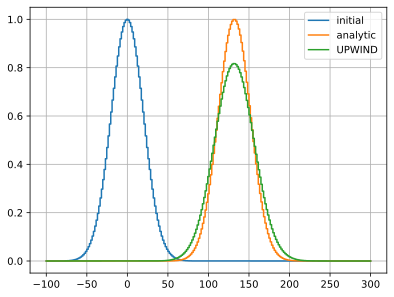

In [7]:
u = 2
t_max = 66

nx = 245
nt = 1000
dt = t_max / nt
x, dx = np.linspace(-100, 300, nx, retstep=True)

plot(
    x=x,
    initial=psi_0(x),
    analytic=psi_0(x - u * t_max),
    UPWIND=solve_upwind(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x))
)

**3. modified equation analysis of the upwind scheme**

While the upwind scheme is conservative, sing-preserving and stable for $|C| \le 1$, it is only [first-order accurate](https://en.wikipedia.org/wiki/Rate_of_convergence) in space ($\Delta x$) and time ($\Delta t$), and incurs [numerical diffusion](https://en.wikipedia.org/wiki/Numerical_diffusion) which can be quantified with the modified-equation analysis by substituting the discretised values other than $\psi_i^n$ in the scheme formula with their Taylor expansions (using the Big O notation):

\begin{align}
\psi_i^{n+1} &= \psi_i^{n} + \frac{\left.\partial_t\psi\right|_i^n}{1!} (\,+\Delta t\,) + \frac{\left.\partial^2_t\psi\right|_i^n}{2!} (\,+\Delta t\,)^2 + O(\Delta t^3) \\
\psi_{i+1}^n &= \psi_i^n + \frac{\left.\partial_x\psi\right|_i^n}{1!} (+\Delta x) + \frac{\left.\partial^2_x\psi\right|_i^n}{2!} (+\Delta x)^2 + O(\Delta x^3)\\
\psi_{i-1}^n &= \psi_i^n + \frac{\left.\partial_x\psi\right|_i^n}{1!} (-\Delta x) + \frac{\left.\partial^2_x\psi\right|_i^n}{2!} (-\Delta x)^2 + O(\Delta x^3)
\end{align}

which yields (up to second-order terms):

\begin{align}
\left.\partial_t\psi\right|_i^n \Delta t + \underbrace{\partial^2_t\psi}_{u^2\partial_x^2\psi}|_i^n \frac{\Delta t^2}{2} &= \frac{C}{2} \left( \psi^n_{i-1} - \psi^n_{i+1}\right) + \frac{|C|}{2} \left( \psi^n_{i-1} - 2 \psi_i^n + \psi^n_{i+1}\right)\\
&=- \,C\, \Delta x \, \partial_x \left.\psi\right|^n_i + \frac{|C|}{2} \,\Delta x^2 \, \partial_x^2\left.\psi\right|^n_i
\end{align}

in which the highlighted second-order time derivative can be replaced with second-order spatial derivative using the Cauchy-Kovalevskaya procedure (i.e., by substituting the advection eq. into its time-derivative giving $\partial^2_t \psi = -u \partial_x \partial_t \psi = u^2 \partial^2_x \psi$) yielding the following, so-called, modified equation:

$$
\partial_t\psi|_i^n + u \partial_x \psi|_i^n = \underbrace{\left(|u| \frac{\Delta x}{2} - u^2 \frac{\Delta t}{2}\right)}_{k}\, \partial_x^2 \psi|_i^n  
$$

which confirms that, as $\Delta t \rightarrow 0$ and $\Delta x \rightarrow 0$, the upwind scheme approximates the advection eq., but the truncation error has a leading-order source term with a coefficient of numerical diffusion given by $k$.

**4. reversing numerical diffusion with MPDATA**

The concept of MPDATA lies in reversing the effect of numerical diffusion by using the pseudo-velocity technique that allows to express diffusion terms in transport problems as advective terms. To this end, Smolarkiewicz ([1983](https://doi.org/10.1175%2F1520-0493%281983%29111%3C0479%3AASPDAS%3E2.0.CO%3B2)) introduced the anti-diffusive pseudo velocity (note the opposite sign stemming from, de facto, integrating backwards in time to reverse the effect of diffusion):

$$
\partial_t\psi + \partial_x \big(\!\!\!\!\!\!\!\!\!\!\!\!\underbrace{k \frac{\partial_x \psi}{\psi}}_\text{anti-diffusive velocity} \!\!\!\!\!\!\!\!\!\!\!\!\psi\big) = 0 
$$
and proposed discretisation allowing to perform a corrective step using upwind integration with an anti-diffusive Courant number field:

$$
C^{m+1}_{i- 1/2 } = \frac{\Delta t}{\Delta x} k^m_{i- 1/2} \left.\frac{\partial_x \psi}{\psi}\right|^m_{i- 1/2} \approx \begin{cases}
0 &\text{  if  } \psi^m_{i}+\psi^m_{i-1} = 0\\
\left[|C^m_{i-1/2}|-(C^m_{i-1/2})^2\right]\frac{\psi^m_{i}-\psi^m_{i-1}}{\psi^m_{i}+\psi^m_{i-1}} &\text{  otherwise  }
\end{cases} 
$$
where $m > 0$ numbers algorithm iterations. The first pass of the scheme is an ordinary upwind integration using $C^{m=1}=C$ and yielding $\psi^{m=1}$. In the second pass, the values of the anti-diffusive Courant number $C^{m=2}$ are computed based on $C^{m=1}$ and $\psi^{m=1}$, and used to perform an upwind anti-diffusive pass yielding $\psi^{m=2}$. Subsequent iterations may be used to correct the integration of the anti-diffusive corrections from previous passes. If $M$ iterations are used, $\psi^{m=M}$ is used as the result of integration of the advective term over one $\Delta t$.

**5. MPDATA algorithm coded in Python/NumPy (incl. time-stepping loop)**

In [8]:
def corrective_C(C:np.ndarray, i:slice, psi:np.ndarray ):
    return (abs(C[i-hlf])-np.pow(C[i-hlf], 2)) * ((psi[i]-psi[i-one])/ (psi[i]+psi[i-one]))   
    #return (abs(C[i-hlf])-np.pow(C[i-hlf], 2)) * ((psi[i]-psi[i-one])/ (psi[i]+psi[i-one] we can add eps here to not divide by 0))   

def solve_mpdata(*, nt: int, C: float, psi: np.ndarray):
    i_ext = slice(1, len(psi))
    for _ in range(nt):
        upwind(psi, slice(1, len(C)), C)
        upwind(psi, slice(1, len(C)), corrective_C(C, i_ext, psi))
    return psi



**6. comparing analytic and numerical solutions**

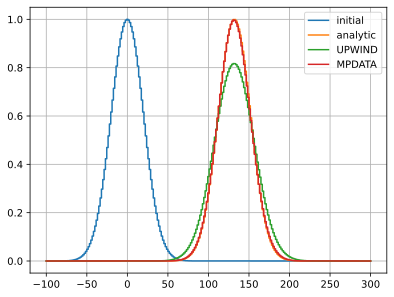

In [9]:
plot(
    x=x, 
    initial=psi_0(x),
    analytic=psi_0(x-u*t_max),
    UPWIND=solve_upwind(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x)),
    MPDATA=solve_mpdata(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x))
)

<center><h1> Assignment05 </h1></center>
<center>02/04/2025</center>
Oleksii Korduba (korduba@student.agh.edu.pl)

In this assignment I implemented iteration correction for MPDATA algorithm. MPDATA it is a numerical method designed to solve advection-dominated equaton. The idea is very simple: start with the upwind solution and apply corrective steps to reduce its diffusion.

In [59]:
def corrective_C(C:np.ndarray, i:slice, psi:np.ndarray ):
    return (abs(C[i-hlf])-np.pow(C[i-hlf], 2)) * ((psi[i]-psi[i-one])/ (psi[i]+psi[i-one]))   
    #return (abs(C[i-hlf])-np.pow(C[i-hlf], 2)) * ((psi[i]-psi[i-one])/ (psi[i]+psi[i-one] we can add eps here to not divide by 0))   

def solve_mpdata(*, nt: int, C: np.ndarray, psi: np.ndarray, n: int = 1):
    for _ in range(nt):
        upwind(psi, slice(1, len(C)), C)
        C_new = C
        for _ in range(n):
            C_new = corrective_C(C_new, slice(1, len(psi)), psi)
            upwind(psi, slice(1, len(C)), C_new)
    return psi




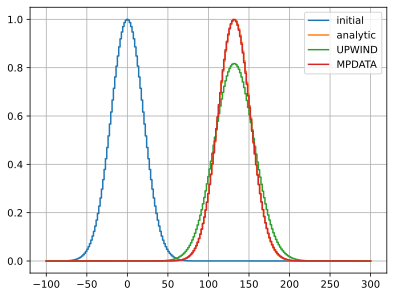

In [60]:
plot(
    x=x, 
    initial=psi_0(x),
    analytic=psi_0(x-u*t_max),
    UPWIND=solve_upwind(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x)),
    MPDATA=solve_mpdata(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x), n=2)
)

In [65]:
n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
result = []
for i in n:
    UPWIND=solve_upwind(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x))
    MPDATA=solve_mpdata(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x), n = i)
    result.append([n, UPWIND , MPDATA])


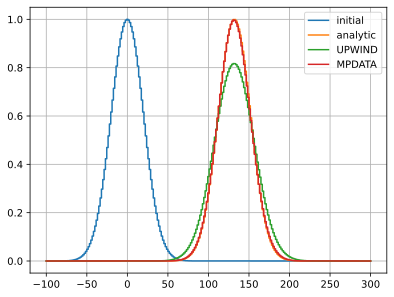

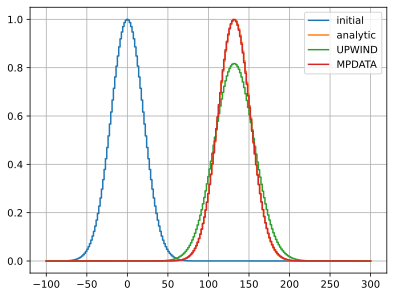

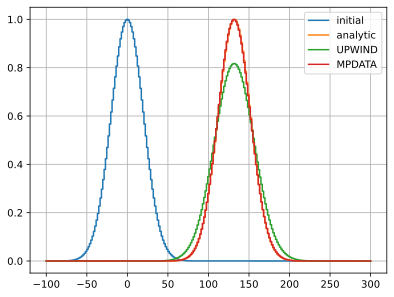

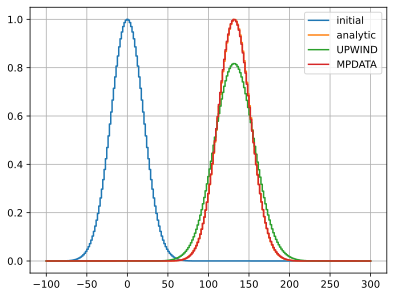

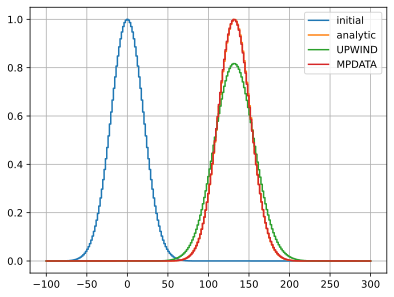

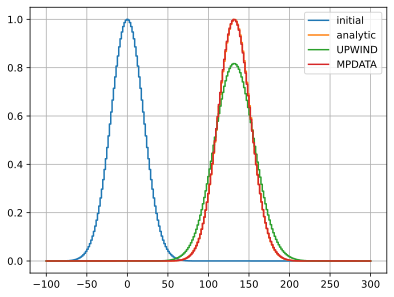

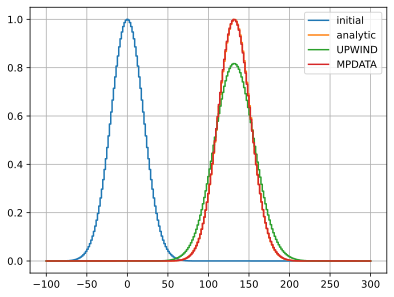

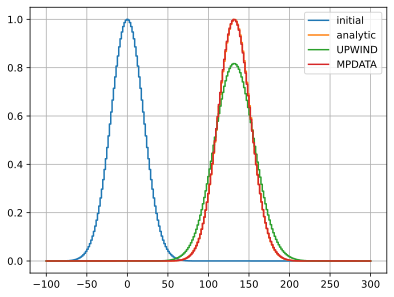

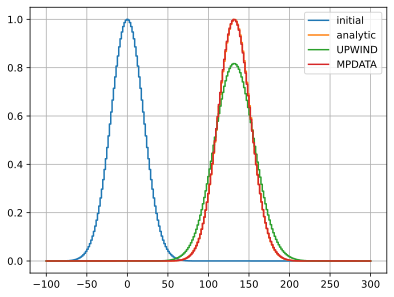

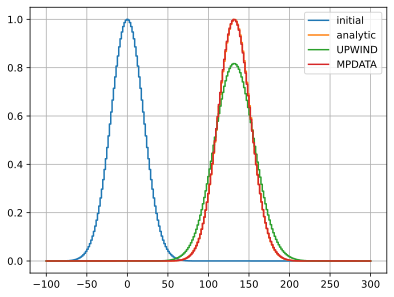

In [68]:
for n, UPWIND, MPDATA in result:
    plot(
    x=x, 
    initial=psi_0(x),
    analytic=psi_0(x-u*t_max),
    UPWIND = UPWIND, 
    MPDATA = MPDATA)

__CONCLUSION__ 


In this assignment I impkemented MPDATA scheme with corrective iteration and vidualized how increasing number of corrective steps improves the solution. It is hard to see in our plots(you have to zoom it really close) but one iteration already improves the result. More iteration takes the numerical solution more closer to the analytical